STAT 453: Deep Learning (Spring 2021)  

Instructor: Sebastian Raschka (sraschka@wisc.edu)  
Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

In [1]:
#%load_ext watermark
#%watermark -a 'Sebastian Raschka' -v -p torch

- Runs on CPU or GPU (if available)

# L03: Perceptrons

Implementation of the classic Perceptron by Frank Rosenblatt for binary classification (here: 0/1 class labels) in PyTorch

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

## Preparing a toy dataset

In [9]:
##########################
### DATASET
##########################

data = np.genfromtxt('mcs_ds_edited_iter_shuffled.csv', delimiter=',', skip_header=1)

X, y = data[:, :4], data[:, 4]
y = y.astype(np.int64)

print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

cutoff = int(y.shape[0] * 0.8 )

X_train, X_test = X[shuffle_idx[:cutoff]], X[shuffle_idx[cutoff:]]
y_train, y_test = y[shuffle_idx[:cutoff]], y[shuffle_idx[cutoff:]]


# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Class label counts: [66 38  3]
X.shape: (107, 4)
y.shape: (107,)


In [10]:
y_train

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 2,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
      dtype=int64)

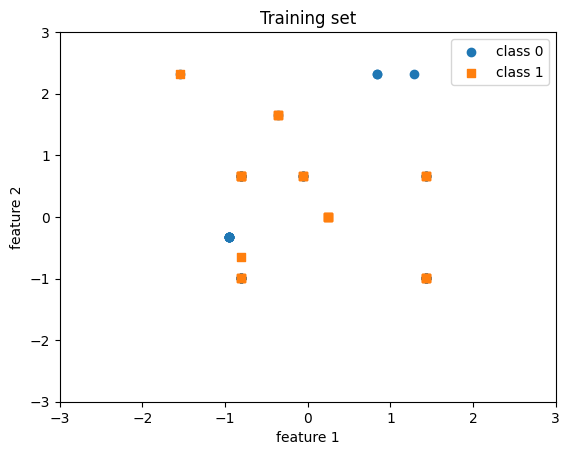

In [11]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.title('Training set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

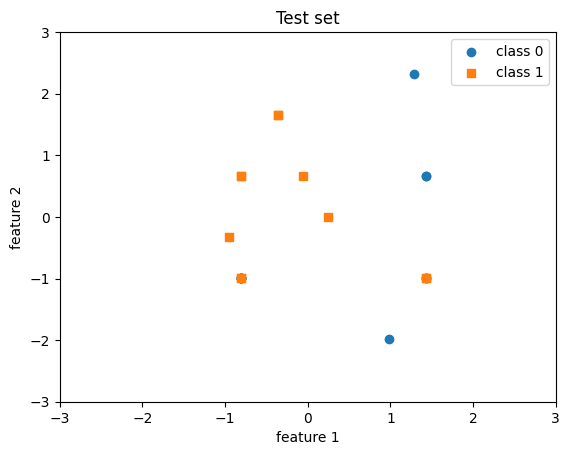

In [12]:
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')
plt.title('Test set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

## Defining the Perceptron model

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Perceptron():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)
        
        # placeholder vectors so they don't
        # need to be recreated each time
        self.ones = torch.ones(1).to('cuda')  #Ahmed: added to.('cuda') to send tensors used in prediction to GPU device
        self.zeros = torch.zeros(1).to('cuda')

    def forward(self, x):
        linear = torch.mm(x, self.weights) + self.bias
        print(linear)
        predictions = torch.where(linear > 0., self.ones, self.zeros)
        return predictions
        
    def backward(self, x, y):  
        predictions = self.forward(x)
        errors = y - predictions
        return errors
        
    def train(self, x, y, epochs):
        for e in range(epochs):
            
            for i in range(y.shape[0]):
                # use view because backward expects a matrix (i.e., 2D tensor)
                errors = self.backward(x[i].reshape(1, self.num_features), y[i]).reshape(-1)
                self.weights += (errors * x[i]).reshape(self.num_features, 1)
                self.bias += errors
                
    def evaluate(self, x, y):
        predictions = self.forward(x).reshape(-1)
        accuracy = torch.sum(predictions == y).float() / y.shape[0]
        return accuracy

## Training the Perceptron

In [14]:
ppn = Perceptron(num_features=4)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

ppn.train(X_train_tensor, y_train_tensor, epochs=100)

print('Model parameters:')
print('  Weights: %s' % ppn.weights)
print('  Bias: %s' % ppn.bias)

tensor([[0.]], device='cuda:0')
tensor([[0.]], device='cuda:0')
tensor([[0.]], device='cuda:0')
tensor([[0.]], device='cuda:0')
tensor([[0.]], device='cuda:0')
tensor([[3.4168]], device='cuda:0')
tensor([[-1.5366]], device='cuda:0')
tensor([[1.9652]], device='cuda:0')
tensor([[1.3206]], device='cuda:0')
tensor([[-4.3632]], device='cuda:0')
tensor([[1.1661]], device='cuda:0')
tensor([[-6.4712]], device='cuda:0')
tensor([[-0.1419]], device='cuda:0')
tensor([[-1.3479]], device='cuda:0')
tensor([[-0.8816]], device='cuda:0')
tensor([[-4.9565]], device='cuda:0')
tensor([[-2.0086]], device='cuda:0')
tensor([[6.3142]], device='cuda:0')
tensor([[0.1023]], device='cuda:0')
tensor([[-4.3237]], device='cuda:0')
tensor([[2.6356]], device='cuda:0')
tensor([[1.4735]], device='cuda:0')
tensor([[-1.8136]], device='cuda:0')
tensor([[-6.0030]], device='cuda:0')
tensor([[2.7471]], device='cuda:0')
tensor([[-3.5461]], device='cuda:0')
tensor([[-9.0068]], device='cuda:0')
tensor([[-2.7028]], device='cuda:0'

## Evaluating the model

In [15]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = ppn.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

tensor([[  2.7575],
        [  6.3400],
        [ -3.2251],
        [  1.4831],
        [  3.7617],
        [-11.0618],
        [ -4.2439],
        [  2.8805],
        [ -3.8006],
        [ -1.7463],
        [  5.8212],
        [ -1.8278],
        [ -6.5224],
        [-17.5011],
        [  1.8617],
        [  6.6195],
        [ -0.0518],
        [ -2.8465],
        [ -0.4304],
        [ -6.4911],
        [-16.3900],
        [  5.3356]], device='cuda:0')
Test set accuracy: 72.73%


c:\Users\SIU856511631\AppData\Local\anaconda3\envs\rcnn\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

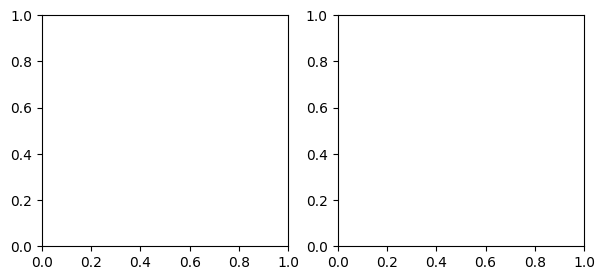

In [16]:
##########################
### 2D Decision Boundary
##########################

w, b = ppn.weights.cpu(), ppn.bias.cpu()  #Ahmed: used .cpu() to send tensors from device to CPU

x0_min = -2
x1_min = ( (-(w[0] * x0_min) - b[0]) 
          / w[1] )

x0_max = 2
x1_max = ( (-(w[0] * x0_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x0_min, x0_max], [x1_min, x1_max])
ax[1].plot([x0_min, x0_max], [x1_min, x1_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()